<h1>DNN Image Classifier</h1>

In [305]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.metrics import Precision, Recall, BinaryAccuracy
from keras.optimizers import Adam
import os
import cv2
import imghdr
from matplotlib import pyplot as plt
import numpy as np

<h2>Clean Data</h2>
<p>Remove anything < 10kp as well as any vector images

In [275]:
data_dir = 'data/people/'
# data_dir = 'data/pets/'
img_extensions = ['jpg', 'jpeg', 'png', 'bmp' ]

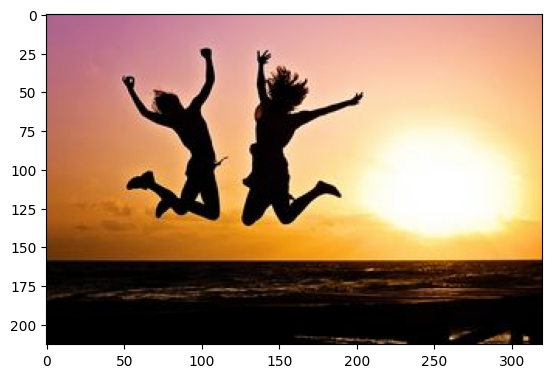

In [276]:
img = cv2.imread(os.path.join('data', 'people', 'happy', '_happy_jumping_on_beach-40815.jpg'))
# img = cv2.imread(os.path.join('data', 'pets', 'dog', 'dogs-playing-556304.jpg'))
# print(f'image format type: {type(img)}')
# print(f'image size: {img.shape}')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [277]:
for img_dir in os.listdir(data_dir):
    if img_dir == '.DS_Store':
        continue
    for img_path in os.listdir(os.path.join(data_dir, img_dir)):
        print(img)
        try: 
            img = cv2.imread(img_path)
            ext = imghdr.what(img_path)
            if ext not in img_extensions:
                print("Image extentions not valid")
                os.remove(img_path)
        except Exception as e:
            print(f"There is a problem with [{img_path}]" )

[[[141  98 171]
  [141  98 171]
  [142  99 172]
  ...
  [135 144 217]
  [134 143 216]
  [134 143 216]]

 [[141  98 171]
  [141  98 171]
  [142  99 172]
  ...
  [135 144 217]
  [135 144 217]
  [134 143 216]]

 [[141  98 171]
  [141  98 171]
  [142  99 172]
  ...
  [134 146 218]
  [133 145 217]
  [133 145 217]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  5   2   0]
  [  3   1   0]
  [  1   1   1]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  3   2   0]
  [  1   2   0]
  [  1   1   1]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  3   2   0]
  [  1   2   0]
  [  0   2   0]]]
There is a problem with [images26.jpg]
None
There is a problem with [images32.jpg]
None
There is a problem with [e162ccda8ce0f197f8863f327add9233.jpg]
None
There is a problem with [05-12-21-happy-people.jpg]
None
There is a problem with [image22.jpeg]
None
There is a problem with [GettyImages-871518740-1024x707.jpg]
None
There is a problem with [7-principles-of-succes

[ WARN:0@158622.907] global loadsave.cpp:244 findDecoder imread_('images26.jpg'): can't open/read file: check file path/integrity
[ WARN:0@158622.910] global loadsave.cpp:244 findDecoder imread_('images32.jpg'): can't open/read file: check file path/integrity
[ WARN:0@158622.910] global loadsave.cpp:244 findDecoder imread_('e162ccda8ce0f197f8863f327add9233.jpg'): can't open/read file: check file path/integrity
[ WARN:0@158622.910] global loadsave.cpp:244 findDecoder imread_('05-12-21-happy-people.jpg'): can't open/read file: check file path/integrity
[ WARN:0@158622.910] global loadsave.cpp:244 findDecoder imread_('image22.jpeg'): can't open/read file: check file path/integrity
[ WARN:0@158622.910] global loadsave.cpp:244 findDecoder imread_('GettyImages-871518740-1024x707.jpg'): can't open/read file: check file path/integrity
[ WARN:0@158622.910] global loadsave.cpp:244 findDecoder imread_('7-principles-of-successful-and-happy-people.png'): can't open/read file: check file path/integr

<h2>Load Data</h2>
<p>Tensorflow has a data set api that allows you to build data pipelines. Rather that loading everything into memory to begin with, it allows you to build a data pipleine which allows you to: </p>
<ul> 
    <li>Scale out to much larger data sets</li>
    <li>Gives you a repeatable set of steps</li>
</ul>

In [278]:
# Builds image data set on the fly along with some pre-processing out of the box - like image resizing
# Build data pipleine
data = tf.keras.utils.image_dataset_from_directory('data/people')
# data = tf.keras.utils.image_dataset_from_directory('data/pets')

Found 305 files belonging to 2 classes.


In [279]:
# convert into numpy iterator 
# Allowing us to loop through data pipleline
data_iterator = data.as_numpy_iterator()

2023-04-02 15:14:15.179311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [305]
	 [[{{node Placeholder/_4}}]]
2023-04-02 15:14:15.180040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [305]
	 [[{{node Placeholder/_4}}]]


In [280]:
# Access data in pipeline
# Two parts: images & labels
batch = data_iterator.next()
batch[0].shape
# 0 = Happy
# 1 = Sad
batch[1]

array([1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 1], dtype=int32)

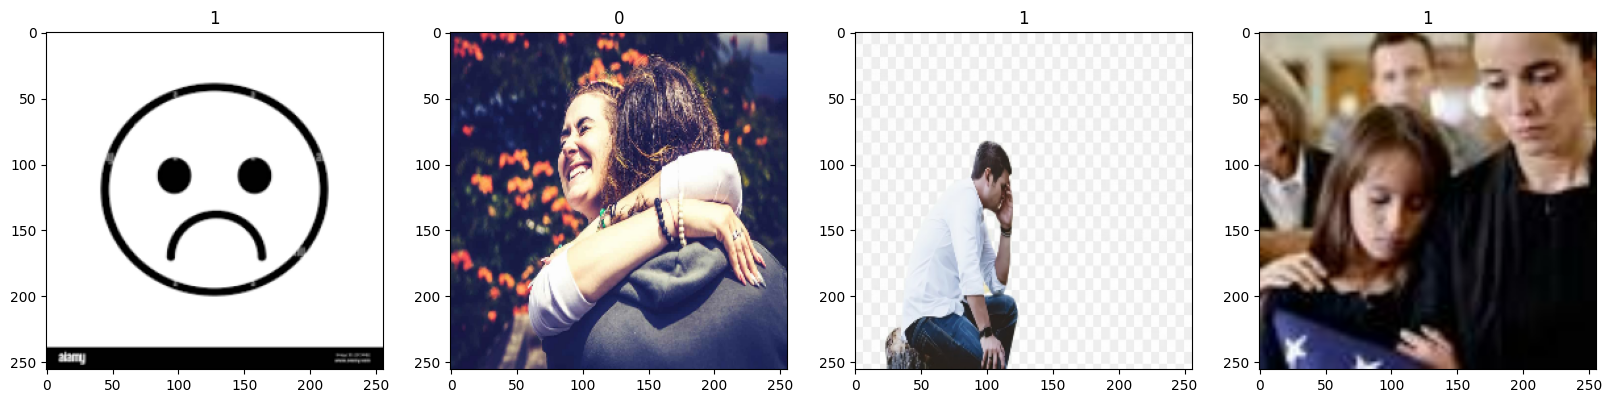

In [281]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for i, img in enumerate(batch[0][0:4]):
    ax[i].imshow(img.astype(int))
    ax[i].title.set_text(batch[1][i])

<h2>Prepare Data for Processing</h2>
<p>Our batches are composed of two components</p>
<ul>
    <li>0 - Images</li>
    <li>1 - Labels</li>
</ul>
<p>When loading an image representation of number of channels (rgb) they are going to be of the values 0 - 255</p>
<h3>Scaling</h3>
<p>To optimize the build of the deep learning model, we want the values to be as small as possible, so we will divide by 255 - scaling our data.</p>
<p>Instead of doing this every time we load up a batch, we will do it as we are loading up the data through the data pipeline. This is more efficient</p>
<p>To achieve this we will use the function 'map' inside the data pipeline.</p>

In [62]:
print(batch[0].min())
print(batch[0].max())

0.0
255.0


In [82]:
# scaled_data = batch[0] / 255
# print(scaled_data.min())
# print(scaled_data.max())

In [327]:
data = tf.keras.utils.image_dataset_from_directory('data/people/')
# data = tf.keras.utils.image_dataset_from_directory('data/pets/')

Found 305 files belonging to 2 classes.


In [328]:
# Scalling our data
# x = images, y = target variable (labels)
data = data.map(lambda x, y: (x/255, y))

In [329]:
scaled_data_iterator = data.as_numpy_iterator()

2023-04-02 15:52:08.246407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [305]
	 [[{{node Placeholder/_4}}]]
2023-04-02 15:52:08.246824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [305]
	 [[{{node Placeholder/_4}}]]


In [295]:
batch = scaled_data_iterator.next()

In [330]:
batch[0].max()

1.0

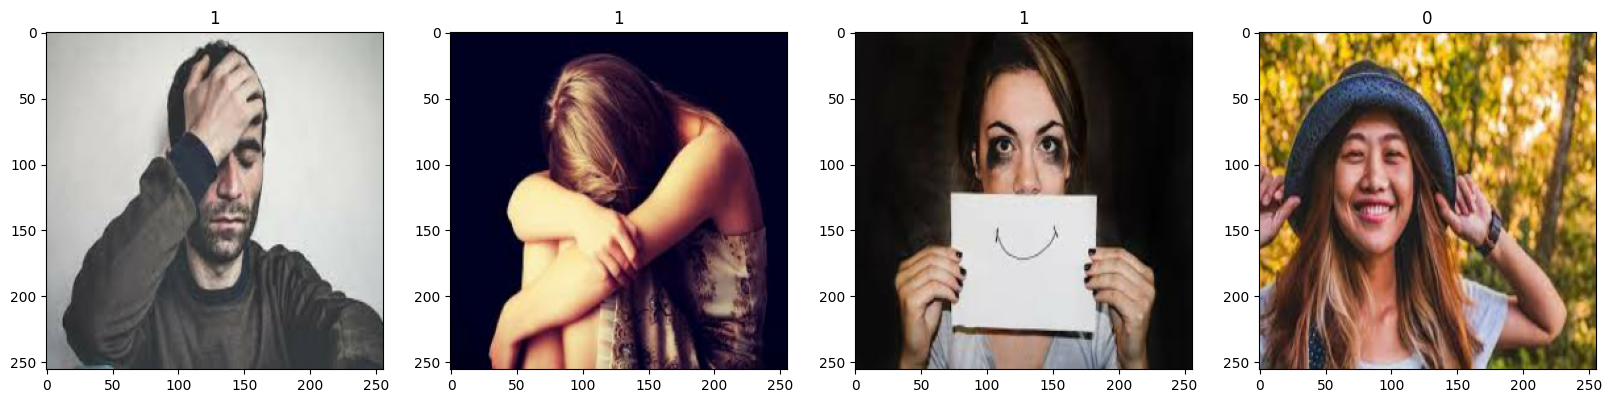

In [331]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for i, img in enumerate(batch[0][0:4]):
    ax[i].imshow(img)
    ax[i].title.set_text(batch[1][i])

In [202]:
len(data)

14

<h2>Split Data</h2>
<ul>
    <li>Training Data: 70%</li>
    <li>Validation Data: 20%</li>
    <li>Test Data: 10%</li>
</ul>

<p>Training data is used to train our deep learning model</p>
<p>Validation data is used to eveluate our model while it's being trained</p>
<p>Test data is used to eveluate our model after it has been trained</p>

In [332]:
train_size = int(len(data) * 0.7)
validation_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1)

In [333]:
# Inside the tenserflow dataset pipline there are the take and skip methods availble.
# The take method defines how much data we are going to take in a particular partition 
# Shuffle data before this step
train = data.take(train_size)
validation = data.skip(train_size).take(validation_size)
test = data.skip(train_size + validation_size).take(test_size)

<h2>Building the DNN</h2>
<ul>
    <li>Build model</li>
    <li>Train</li>
    <li>Plot Performance</li>
</ul>

<h3>Libraries used:</h3>
<ul>
    <li>
        <p>Sequential: Model building api</p>
    </li>
    <li>
        <p>Conv2D: convolutional neural network layer</p>
    </li>
    <li>
        <p> MaxPool2D: </p>
    </li>
    <li>
        <p>Dense: </p>
    </li>
    <li>
        <p>Flatten: </p>
    </li>
</ul>


In [334]:
model = Sequential()

In [335]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [337]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [338]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 30, 30, 16)      

In [339]:
log_dir = 'logs'

In [340]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [341]:
history = model.fit(train, epochs=20, validation_data=validation, callbacks=[tensorboard_callback])

Epoch 1/20


2023-04-02 15:52:46.009741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [305]
	 [[{{node Placeholder/_4}}]]
2023-04-02 15:52:46.010189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [305]
	 [[{{node Placeholder/_4}}]]


7/7 [==============================] - ETA: 0s - loss: 0.9941 - accuracy: 0.5670

2023-04-02 15:52:54.650029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [305]
	 [[{{node Placeholder/_4}}]]
2023-04-02 15:52:54.650577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [305]
	 [[{{node Placeholder/_4}}]]


7/7 [==============================] - 12s 1s/step - loss: 0.9941 - accuracy: 0.5670 - val_loss: 0.6041 - val_accuracy: 0.7031
Epoch 2/20
7/7 [==============================] - 9s 1s/step - loss: 0.6105 - accuracy: 0.6607 - val_loss: 0.5495 - val_accuracy: 0.7031
Epoch 3/20
7/7 [==============================] - 9s 1s/step - loss: 0.5069 - accuracy: 0.7902 - val_loss: 0.4165 - val_accuracy: 0.7969
Epoch 4/20
7/7 [==============================] - 9s 1s/step - loss: 0.4748 - accuracy: 0.7723 - val_loss: 0.4898 - val_accuracy: 0.8438
Epoch 5/20
7/7 [==============================] - 10s 1s/step - loss: 0.4871 - accuracy: 0.7768 - val_loss: 0.3932 - val_accuracy: 0.8594
Epoch 6/20
7/7 [==============================] - 8s 937ms/step - loss: 0.3082 - accuracy: 0.8795 - val_loss: 0.2463 - val_accuracy: 0.8281
Epoch 7/20
7/7 [==============================] - 8s 929ms/step - loss: 0.2139 - accuracy: 0.8839 - val_loss: 0.1558 - val_accuracy: 0.9375
Epoch 8/20
7/7 [============================

In [342]:
history.history

{'loss': [0.9941457509994507,
  0.6104971170425415,
  0.5069160461425781,
  0.47481685876846313,
  0.48708412051200867,
  0.30823975801467896,
  0.21386167407035828,
  0.1972000151872635,
  0.14875803887844086,
  0.08522899448871613,
  0.07034635543823242,
  0.06574857980012894,
  0.041389305144548416,
  0.037615709006786346,
  0.029023827984929085,
  0.060706522315740585,
  0.026659654453396797,
  0.018733778968453407,
  0.021348563954234123,
  0.02891353890299797],
 'accuracy': [0.5669642686843872,
  0.6607142686843872,
  0.7901785969734192,
  0.7723214030265808,
  0.7767857313156128,
  0.8794642686843872,
  0.8839285969734192,
  0.9419642686843872,
  0.9642857313156128,
  0.9732142686843872,
  0.9776785969734192,
  0.9866071343421936,
  0.9910714030265808,
  0.9955357313156128,
  0.9955357313156128,
  0.9821428656578064,
  0.9955357313156128,
  0.9955357313156128,
  0.9910714030265808,
  0.9821428656578064],
 'val_loss': [0.6041407585144043,
  0.5494997501373291,
  0.416495561599731

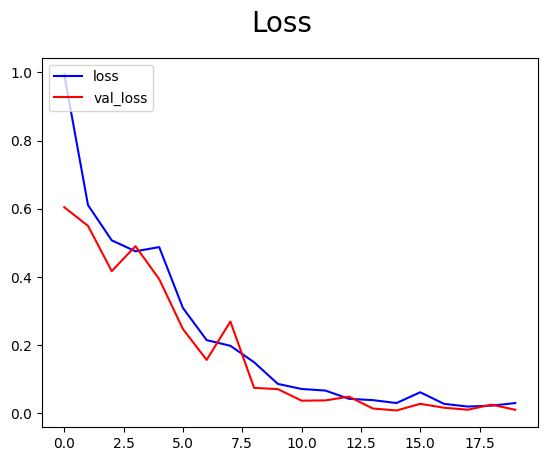

In [345]:
fig = plt.figure()
plt.plot(history.history['loss'], color='blue', label='loss')
plt.plot(history.history['val_loss'], color='red', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

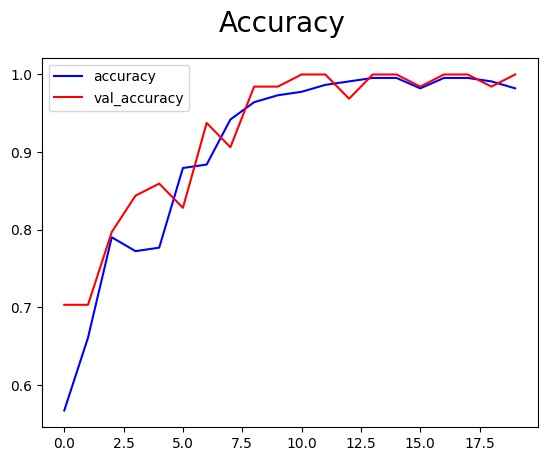

In [344]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='blue', label='accuracy')
plt.plot(history.history['val_accuracy'], color='red', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

<h1>Performance Evaluation</h1>

In [350]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [351]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

precision_val = precision.result()
recall_val = recall.result()
accuracy_val = accuracy.result()

f1_score = 2 * (precision_val * recall_val) / (precision_val + recall_val)

1/1 [==============================] - 0s 100ms/step


In [353]:
print(f"Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, Accuracy: {accuracy_val:.4f}, F1 Score: {f1_score:.4f}")
# print(f'precision: {precision.result()}, Recall: {recall.result()}, Accuracy: {accuracy.result()}')

Precision: 1.0000, Recall: 1.0000, Accuracy: 1.0000, F1 Score: 1.0000


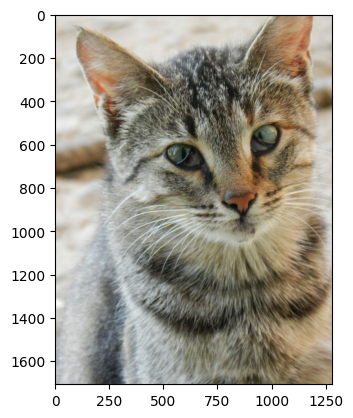

In [250]:
# img = cv2.imread('happy_test.jpg')
# img = cv2.imread('sad_test.jpg')
# img = cv2.imread('dog_test.jpg')
img = cv2.imread('cat_test.jpeg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

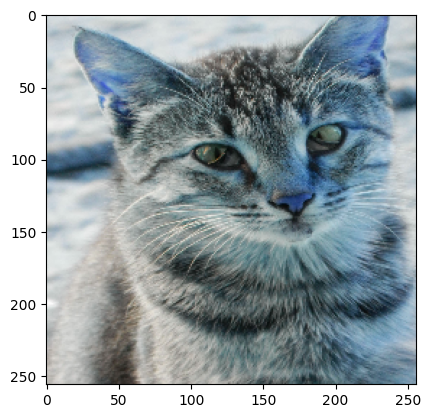

In [251]:
resize = tf.image.resize(img, (256,256))
plt.imshow((resize.numpy().astype(int)))
plt.show()

In [252]:
# np.expand_dims(resize, 0)
y_hat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 129ms/step


In [253]:
y_hat

array([[0.22335981]], dtype=float32)

In [254]:
if y_hat > 0.5: 
    print(f'Predicted class is a Dog')
else:
    print(f'Predicted class is Cat')
# if y_hat > 0.5: 
#     print(f'Predicted class is Sad')
# else:
#     print(f'Predicted class is Happy')

Predicted class is Cat


In [255]:
# model.save(os.path.join('models','peopleclassifier.h5'))
model.save(os.path.join('models','petclassifier.h5'))

In [256]:
new_model = load_model(os.path.join('models','petclassifier.h5'))

In [261]:
y_hat_load = new_model.predict(np.expand_dims(resize/255, 0))
y_hat_load

1/1 [==============================] - 0s 33ms/step


array([[0.22335981]], dtype=float32)